In [1]:
import pandas as pd
import numpy as np
import os
import pyodbc
import sqlalchemy
import urllib
import datetime
import plotly.express as px
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import Image
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.offline as offline

## unique Данные по добыче для выгрузки в бизнес шаблоны

In [4]:
os.chdir(r'd:\project\Minnib_project\SCHED_PATTERNS\reports')

In [3]:
df = pd.read_csv('wells_to_invest.csv')

In [4]:
df.columns

Index(['Unnamed: 0', 'well', 'Parametr0', 'Parametr1', 'Parametr2',
       'Parametr3', 'Parametr4', 'Parametr5', 'Parametr6', 'Parametr7',
       'Parametr8', 'Parametr9'],
      dtype='object')

In [5]:
df.columns=['date', 'well', 'lpt', 'lpr', 'opt', 'opr', 'wir', 'wit', 'press', 'bhp', 'pio', 'piw']

In [6]:
df['shifted']=df['lpt'].shift(1, fill_value=0)+df['wit'].shift(1, fill_value=0)

In [7]:
df['drilled_p'] = (df['shifted']==0)&(df['lpr']>0)
df['drilled_i'] = (df['shifted']==0)&(df['wir']>0)

In [8]:
df['prodaction'] = df['pio']+df['piw']
#df.loc[df['lpr']>0, 'prodaction'] = df['lpr']/(df['press']-df['bhp'])
#df.loc[df['wir']>0, 'prod'] = df['wir']/(df['bhp']-df['press'])
df['shifted_P']=df['prodaction'].shift(1, fill_value=0)

In [9]:
def fond_analizator (frame, oil_dens=0.865, wat_dens=1.05):
    frame['drilled_p'] = (frame['shifted']==0)&(frame['lpr']>0)
    frame['drilled_i'] = (frame['shifted']==0)&(frame['wir']>0)  
    frame['GTM'] = (frame['opr']/frame['opr'].shift(1)>1.3)  
    frame['VNS'] = (frame['drilled_i']==False)&(frame['wir'].shift(1)==0)&(frame['wir'].shift(2)==0)&(frame['wir'].shift(3)==0)\
                    &(frame['wir'].shift(4)==0)&(frame['wir'].shift(5)==0)&(frame['wir'].shift(6)==0)\
                    &(frame['wir'].shift(7)==0)&(frame['wir'].shift(8)==0)&(frame['wir'].shift(9)==0)\
                    &(frame['wir'].shift(10)==0)&(frame['wir'].shift(11)==0)&(frame['wir'].shift(12)==0)\
                    &(frame['wir']>0)  
    frame['VDS'] = (frame['drilled_p']==False)&(frame['lpr'].shift(1)==0)&(frame['lpr'].shift(2)==0)&(frame['lpr'].shift(3)==0)\
                    &(frame['lpr'].shift(4)==0)&(frame['lpr'].shift(5)==0)&(frame['lpr'].shift(6)==0)\
                    &(frame['lpr'].shift(7)==0)&(frame['lpr'].shift(8)==0)&(frame['lpr'].shift(9)==0)\
                    &(frame['lpr'].shift(10)==0)&(frame['lpr'].shift(11)==0)&(frame['lpr'].shift(12)==0)\
                    &(frame['lpr']>0)  
    frame['prod'] = (frame['date'].dt.month==12)&(frame['lpr']>0)  
    frame['inj'] = (frame['date'].dt.month==12)&(frame['wir']>0)  
    frame['year_oil'] = (frame['date'].dt.month==12)&(frame['wir']>0)  
    frame['year_liq'] = (frame['date'].dt.month==12)&(frame['wir']>0)  
    frame['year_wat'] = (frame['date'].dt.month==12)&(frame['wir']>0)  
    frame['month_oil'] = frame['opt'].diff()
    frame['month_oil'].fillna(frame['opt'].min(), inplace=True)
    frame['month_liq'] = frame['lpt'].diff()
    frame['month_liq'].fillna(frame['lpt'].min(), inplace=True)
    frame['month_inj'] = frame['wit'].diff()
    frame['month_inj'].fillna(frame['wit'].min(), inplace=True)
    frame['frack'] = (frame['shifted_P']>0)&\
                    (frame['press']-frame['bhp']>0.1)&\
                    (frame['opr']/frame['opr'].shift(1)>1.1)&\
                    (frame['lpr']>0)&(frame['prodaction']/frame['shifted_P']>1.2)  
    frame['MUN_VIR'] = (frame['shifted_P']>0)&(frame['prodaction']>0)&(frame['lpr']>0)&\
                        (frame['press']-frame['bhp']>0.1)&\
                        (frame['frack'].shift(1)!=True)&\
                        (frame['lpr'].shift(1)!=0)&\
                        (frame['bhp']>0)&(frame['prodaction']/frame['shifted_P']<0.6)  
    frame['MUN_nag'] = (frame['shifted_P']>0)&(frame['wir']>0)&\
                        (frame['wir'].shift(1)!=0)&\
                        (frame['bhp']>0)&(frame['prodaction']/frame['shifted_P']<0.6)&\
                        (frame['prodaction']/frame['shifted_P']>1.2)  
    frame['MUN_OTKL'] = (frame['shifted_P']>0)&(frame['wir']>0)&\
                        (frame['wir'].shift(1)!=0)&\
                        (frame['prodaction']/frame['shifted_P']<0.8)  
    frame['KRS_GNO'] = (frame['shifted_P']>0)&(frame['opr']/frame['lpr'].shift(1)>1.2)&(frame['prodaction']/frame['shifted_P']<1.2)  
    return frame

In [10]:
df['date']=pd.to_datetime(df['date'])

In [11]:
df=pd.DataFrame(df.groupby(by='well').apply(fond_analizator))

In [12]:
sample = df[df['well']=='9645']
sample.index=sample['date']
sample[['lpr', 'wir', 'press', 'bhp', 'prodaction', 'shifted_P', 'MUN_VIR', 'frack', 'MUN_nag', 'MUN_OTKL']].head(60)#.resample('1y').sum()

,lpr,wir,press,bhp,prodaction,shifted_P,MUN_VIR,frack,MUN_nag,MUN_OTKL
date,,,,,,,,,,
2020-01-01,0.0,0.000000,168.714137,168.570116,0.115741,0.000000,False,False,False,False
2020-02-01,0.0,0.000000,168.704182,168.554614,0.115743,0.115741,False,False,False,False
2020-03-01,0.0,0.000000,168.670437,168.513622,0.115745,0.115743,False,False,False,False
2020-04-01,0.0,0.000000,168.622491,168.458298,0.115746,0.115745,False,False,False,False
2020-05-01,0.0,0.000000,168.569718,168.399089,0.115747,0.115746,False,False,False,False
2020-06-01,0.0,0.000000,168.513821,168.337632,0.115747,0.115747,False,False,False,False
2020-07-01,0.0,0.000000,168.483282,168.305299,0.115747,0.115747,False,False,False,False
2020-08-01,0.0,0.000000,168.495380,168.320264,0.115747,0.115747,False,False,False,False
2020-09-01,0.0,0.000000,168.548447,168.380009,0.115745,0.115747,False,False,False,False


In [13]:
df.loc[(df['date'].dt.year==2022)&(df['MUN_OTKL']==True)]

,date,well,lpt,lpr,opt,opr,wir,wit,press,bhp,...,year_liq,year_wat,month_oil,month_liq,month_inj,frack,MUN_VIR,MUN_nag,MUN_OTKL,KRS_GNO
59942,2022-08-01,9645,54050.021127,0.0,54047.498079,0.0,6.634188,516.024397,195.653834,340.0,...,False,False,0.0,0.0,205.659814,False,False,False,True,False
189538,2022-08-01,I-1402,0.000000,0.0,0.000000,0.0,54.726979,4008.567078,199.057989,340.0,...,False,False,0.0,0.0,1696.536340,False,False,False,True,False
333071,2022-08-01,20440,30452.301838,0.0,10698.482454,0.0,20.651320,50807.719267,183.321504,340.0,...,False,False,0.0,0.0,506.173362,False,False,False,True,False


In [14]:
agg_dict = {'month_liq':'sum', 'month_oil':'sum', 'month_inj':'sum','prod':'sum', 'inj':'sum', 'drilled_p':'sum', \
            'drilled_i':'sum', 'GTM':'sum', 'VNS':'sum', 'VDS':'sum', 'frack':'sum','MUN_VIR':'sum', 'MUN_nag':'sum', \
           'MUN_OTKL':'sum', 'MUN_OTKL':'sum', 'KRS_GNO':'sum'}

almost_all = df.loc[:,['date', 'month_liq', 'month_oil', 'month_inj','prod', 'inj', 'drilled_p', 'drilled_i', 'GTM', 'VNS', 'VDS', \
                      'frack', 'MUN_VIR', 'MUN_nag', 'MUN_OTKL', 'KRS_GNO']]\
.groupby(df['date'].dt.year).agg(agg_dict)
almost_all

,month_liq,month_oil,month_inj,prod,inj,drilled_p,drilled_i,GTM,VNS,VDS,frack,MUN_VIR,MUN_nag,MUN_OTKL,KRS_GNO
date,,,,,,,,,,,,,,,
2020,6.801039e+08,2.836533e+08,7.809628e+08,491,381,11,4,566,0,0,10,124,0,193,154
2021,5.559214e+06,1.183631e+06,6.761640e+06,573,392,1,3,105,16,4,0,18,0,1,20
2022,9.763568e+06,2.018212e+06,1.107789e+07,953,527,455,124,589,11,18,101,0,0,3,24
2023,1.304515e+07,2.356851e+06,1.411012e+07,926,527,0,0,0,0,0,0,0,0,0,0
2024,1.264570e+07,1.992385e+06,1.362683e+07,908,527,0,0,0,0,0,0,0,0,0,0
2025,1.229753e+07,1.755541e+06,1.321980e+07,900,527,0,0,0,0,0,0,0,0,0,0
2026,1.203619e+07,1.582625e+06,1.291515e+07,891,527,0,0,0,1,0,0,0,0,0,0
2027,1.186845e+07,1.449977e+06,1.271581e+07,879,527,0,0,0,0,0,0,0,0,0,0
2028,1.160943e+07,1.345594e+06,1.242557e+07,868,527,0,0,0,0,0,0,0,0,0,0


In [17]:
almost_all.values.tolist()

[[680103850.3294829,
  283653303.1881161,
  780962833.4826045,
  491.0,
  381.0,
  11.0,
  4.0,
  566.0,
  0.0,
  0.0,
  10.0,
  124.0,
  0.0,
  193.0,
  154.0],
 [5559214.082781865,
  1183630.8111907935,
  6761640.469781686,
  573.0,
  392.0,
  1.0,
  3.0,
  105.0,
  16.0,
  4.0,
  0.0,
  18.0,
  0.0,
  1.0,
  20.0],
 [9763567.949304385,
  2018212.0777736541,
  11077890.42949837,
  953.0,
  527.0,
  455.0,
  124.0,
  589.0,
  11.0,
  18.0,
  101.0,
  0.0,
  0.0,
  3.0,
  24.0],
 [13045148.435052654,
  2356851.438596967,
  14110118.77861237,
  926.0,
  527.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [12645702.229648435,
  1992385.3292640767,
  13626825.54219456,
  908.0,
  527.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [12297527.55315975,
  1755541.1963317837,
  13219801.850325657,
  900.0,
  527.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [12036189.2392845,
  1582624.980902812,
  12915148.346

# Обработка данных по площадным и линейным объектам

In [5]:
import transliterate

In [31]:
os.chdir(r'd:\project\Minnib_project\SCHED_PATTERNS\reports')

In [45]:
dk_frame=pd.read_excel('to_remove.xlsx')

In [46]:
dk_frame.columns=['date', 'group', 'lpt', 'wpt', 'opt', 'gpt','wit']

In [6]:
dk_frame['date']=pd.to_datetime(dk_frame['date'])
dk_frame.set_index(['date'], inplace=True)

In [7]:
dk_frame=dk_frame[dk_frame['group'].str.match('MINN|DNS*|GZU*|KNS*|MTP|TTP')]

In [8]:
def monthly_prod(frame, oil_dens=0.862, wat_dens=1):
    frame['нефть, тыс.т/год'] = frame['opt'].diff()/1000*oil_dens
    frame['нефть, тыс.т/год'].fillna(frame['opt'].min()/1000*oil_dens, inplace=True)
    frame['жидкость, тыс.м3/год'] = frame['lpt'].diff()/1000
    frame['жидкость, тыс.м3/год'].fillna(frame['lpt'].min(), inplace=True)
    frame['вода, тыс.м3/год'] = frame['wpt'].diff()/1000
    frame['вода, тыс.м3/год'].fillna(frame['wpt'].min(), inplace=True)
    frame['газ, тыс.м3/год'] = frame['gpt'].diff()/1000
    frame['газ, тыс.м3/год'].fillna(frame['gpt'].min(), inplace=True)
    frame['газовый фактор, м3/м3']=frame['газ, тыс.м3/год']/(frame['нефть, тыс.т/год']/oil_dens)
    frame['закачка, тыс.м3/год'] = frame['wit'].diff()/1000
    frame['закачка, тыс.м3/год'].fillna(frame['wit'].min(), inplace=True)
    cum = [i for i in frame.columns if 't' in i]
    frame.drop(columns=cum, inplace=True)
    return frame

In [9]:
dk_frame=pd.DataFrame(dk_frame.groupby(by='group').apply(monthly_prod))

In [10]:
dk_frame

,group,"нефть, тыс.т/год","жидкость, тыс.м3/год","вода, тыс.м3/год","газ, тыс.м3/год","газовый фактор, м3/м3","закачка, тыс.м3/год"
date,,,,,,,
2020-01-01,DNS-10,0.000000,0.000000,0.000000,0.000000,NaN,0.0
2020-02-01,DNS-10,0.000000,0.000000,0.000000,0.000000,NaN,0.0
2020-03-01,DNS-10,0.000000,0.000000,0.000000,0.000000,NaN,0.0
2020-04-01,DNS-10,0.000000,0.000000,0.000000,0.000000,NaN,0.0
2020-05-01,DNS-10,0.000000,0.000000,0.000000,0.000000,NaN,0.0
...,...,...,...,...,...,...,...
2034-09-01,TTP2,4.049114,33.568953,28.871605,348.725009,74.238700,0.0
2034-10-01,TTP2,3.904043,32.467958,27.938906,336.257176,74.244482,0.0
2034-11-01,TTP2,4.018717,33.529909,28.867824,346.161753,74.250420,0.0


In [12]:
from transliterate import translit
dk_frame['group']=dk_frame['group'].apply(lambda x: translit(x, 'ru'))


In [13]:
noGOR=dk_frame.groupby('group').apply(lambda x: x.resample('1y').sum())#.stack().unstack(1)#.to_excel('frame_rem.xlsx')j

In [48]:
noGOR

нефть, тыс.т/год  жидкость, тыс.м3/год  вода, тыс.м3/год  \
group date                                                                   
ГЗУ-1 2020-12-31          0.000000              0.000000          0.000000   
      2021-12-31          2.984295             31.058235         27.596176   
      2022-12-31         32.988213            130.497464         92.228076   
      2023-12-31         42.814267            221.423021        171.754497   
      2024-12-31         34.293301            219.286172        179.502760   
...                            ...                   ...               ...   
ТТП2  2031-12-31         55.613594            401.414001        336.897071   
      2032-12-31         53.058668            401.427753        339.874774   
      2033-12-31         50.375387            398.028292        339.588167   
      2034-12-31         48.129568            395.746466        339.911700   
      2035-12-31          3.988242             33.486793         28.860062   

                  газ, тыс.м3/год  газовый фактор, м3/м3  закачка, тыс.м3/год  
group date                                                                     
ГЗУ-1 2020-12-31         0.000000                    NaN                  0.0  
      2021-12-31       273.743834              79.069649                  0.0  
      2022-12-31      3022.897259              78.989955                  0.0  
      2023-12-31      3922.906296              78.981738                  0.0  
      2024-12-31      3142.059515              78.979136                  0.0  
...                           ...                    ...                  ...  
ТТП2  2031-12-31      4774.842577              74.009141                  0.0  
      2032-12-31      4559.364561              74.072200                  0.0  
      2033-12-31      4332.831108              74.141374                  0.0  
      2034-12-31      4144.185318              74.222310                  0.0  
      2035-12-31       343.590575              74.262070                  0.0  

[2096 rows x 6 columns]

In [41]:
noGOR['газовый фактор, м3/м3']=noGOR['газ, тыс.м3/год']/(noGOR['нефть, тыс.т/год']/0.862)
noGOR.stack().unstack(1).to_excel('frame_rem.xlsx')

In [52]:
ddd = noGOR.stack().unstack(1).reset_index().values.tolist()

In [54]:
len(ddd[0])

18

# Подготовка данных со сглаживанием

In [3]:
from scipy import signal

In [4]:
def interpolate_press_by_sipy(frame, a=2, b=0.1):
	b, a = signal.butter(a,b)
	if frame.shape[0]>12:
		frame.index=frame['date']
		frame['SBHPH']= signal.filtfilt(b, a, frame['BHPH'].interpolate(method='time').fillna(method='bfill')) 
		frame['STHPH']= signal.filtfilt(b, a, frame['THPH'].interpolate(method='time').fillna(method='bfill')) 
		frame.loc[frame['BHPH'].interpolate(method='time').isnull(), 'SBHPH'] = np.NaN
		frame.loc[frame['THPH'].interpolate(method='time').isnull(), 'STHPH'] = np.NaN
		frame.loc[(frame['status']=='not_work'), 'SBHPH'] = np.NaN
		frame.reset_index(drop=True, inplace=True)
	else:
		frame['SBHPH']= np.NaN 
		frame['STHPH']= np.NaN
	return frame
	
def interpolate_prod_by_sipy(frame, a=2, b=0.05):
    b, a = signal.butter(a, b)
    if frame.shape[0] > 12:
        frame.index = frame['date']
        frame['SQLIQ'] = signal.filtfilt(
            b, a, frame['QLIQ'].interpolate(method='time').fillna(method='bfill'))
        frame.loc[(frame['status'] == 'not_work'), 'SQLIQ'] = 0
        frame.loc[(frame['status'] == 'inj'), 'SQLIQ'] = 0
        frame['SWCT'] = signal.filtfilt(
            b, a, frame['WCT'].interpolate(method='time').fillna(method='bfill'))
        frame.loc[(frame['status'] == 'not_work'), 'SWCT'] = 0
        frame.loc[(frame['status'] == 'inj'), 'SWCT'] = 0
        frame.reset_index(drop=True, inplace=True)
    else:
        frame['SQLIQ'] = np.NaN
        frame['SWCT'] = np.NaN
    return frame

In [5]:
def histor_smoothing(df):
	"""Relives and smoothes pressure in source data
	:arg1: TODO
	:kwarg: navigator API keyword = {'grou':get_all_groups(),
									'wells':get_all_wells(),
									'mod': get_all_models(),
									'step':get_all_timesteps()} 
	:returns: pandas DataFrame with smoothing press
	"""
	df['QLIQ'] = df['QOIL']+df['QWAT']
	df['WCT']=(df['QLIQ']-df['QOIL'])/df['QLIQ']
	df['status'] = 'prod'
	df.loc[df['QWIN']>0, 'status'] = 'inj'
	df.loc[((df['QWIN']==0)&(df['QLIQ']==0)), 'status'] = 'not_work'
	df.loc[((df['QWAT']>0)&(df['QOIL']==0)), 'status'] = 'water_prod'
	df['THPH']=df['THPH'].replace([-999,0], np.nan)
	df['BHPH']=df['BHPH'].replace([-999,0], np.nan)
	df.loc[((df['BHPH']>df['THPH'])&(df['status']=='prod')), 'THPH'] = np.NaN
	df=pd.DataFrame(df.groupby(by='well').apply(interpolate_press_by_sipy))
	df.reset_index(drop=True, inplace=True)
	df=pd.DataFrame(df.groupby(by='well').apply(interpolate_prod_by_sipy))
	df.reset_index(drop=True, inplace=True)
	df.loc[df['QLIQ'].isnull(), 'SPROD'] = np.NaN
	df['SOIL']=df['SQLIQ']*(1-df['SWCT'])
	df['SPROD']=df['SQLIQ']/(df['STHPH']-df['SBHPH'])
	df['PROD']=df['QLIQ']/(df['THPH']-df['BHPH'])
	df.loc[df['QLIQ'].isnull(), 'SPROD'] = np.NaN
	df['SPROD']=df['SQLIQ']/(df['STHPH']-df['SBHPH'])
	df['PROD']=df['QLIQ']/(df['THPH']-df['BHPH'])
	df.loc[df['QLIQ'].isnull(), 'SPROD'] = np.NaN
	return df

In [5]:
df=pd.read_table(r'e:\FOX_EXPORT\Samara\RDS_export\hist.inc', skiprows=15, 
                 usecols=['--WELL',"'DD.MM.YYYY'", 'QOIL', 'QWAT', 'QWIN', 'BHPH', 'THPH', 'QLIQ'])
df.columns=['well', 'date', 'QOIL', 'QWAT', 'QWIN', 'BHPH', 'THPH', 'QLIQ']
df['well'] = df['well'].astype('str')
df['date']=pd.to_datetime(df['date'], format = '%d.%m.%Y')

In [350]:
df = histor_smoothing(df)

## Подключение к локальной базе с Ромашкой

In [6]:
os.chdir(r'C:\aiom\OUT\02.03.2021 12.28.25')

In [7]:
import sqlite3

con = sqlite3.connect('ROMA.db')
engine = sqlalchemy.create_engine('sqlite:///ROMA.db')

In [8]:
base = pd.read_sql('select SKW, DAT, AVG(T_EKS) as T_EKS, sum(NEFT) as NEFT, sum(WAT) as WAT, sum(ZAK_T) as ZAK \
from wells \
where PLO = 905 and gor in (528, 529, 531)\
group by SKW, DAT', engine, parse_dates = ['DAT'])

In [9]:
base.columns=['well','date','T_EKS','NEFT', 'WAT','ZAK_T']

In [10]:
base['QOIL'] = base['NEFT']/base['T_EKS']*24
base['QWAT'] = base['WAT']/base['T_EKS']*24
base['QWIN']= base['ZAK_T']/base['T_EKS']*24
base['QLIQ']= base['QOIL']+base['QWAT']
base['THPH']=100
base['BHPH']=50
base.index = base['date']

In [11]:
base = histor_smoothing(base)

In [12]:
base['SOIL'].fillna(base['QOIL'], inplace=True)

In [13]:
df = base

## Подключение к базам данных Армитс

In [68]:
import urllib 
params = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.240.6.3,1433;DATABASE=bd_skw;UID=user_ctr;PWD=!@#qweASD") 
engine = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params) 


In [5]:
import pyodbc 
# Some other example server values are
# server = 'localhost\sqlexpress' # for a named instance
# server = 'myserver,port' # to specify an alternate port
server = '10.240.6.3,1433' #
database = 'bd_skw' 
username = 'user_ctr' 
password = '!@#qweASD' 
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+password)
cursor = cnxn.cursor()

## Импорт данных по скважинам для режимов

In [6]:
query = "select distinct s.id as skw_id,td.fl_skw, s.ngdu,s.cex,s.skw_nam,sav.nam,sav1.nam,ss.kod,ss3.nam, \
td.qg_fak,td.qn_fak,td.obw_fak,td.dni_rab,td.wr_rab,td.pplast,td.pzab,ss4.nam2 \
from texreg_d td \
left outer join skw s on s.id=td.skw_id \
left outer join spr_activ sav on s.activ_id=sav.id \
left outer join spr_activ sav1 on sav1.id=sav.parent_id \
left outer join obj_razr obj on obj.skw_id=s.id and obj.prizn_opl=1 \
left outer join sprskw ss on ss.id=obj.goriz and ss.tip=32 \
left outer join sprskw ss1 on ss1.id=obj.pl \
left outer join sprskw ss2 on ss2.id=obj.mest \
left outer join sprskw ss3 on ss3.id=td.sposob \
left outer join plast pl on pl.skw_id=s.id \
left outer join sprskw ss4 on ss4.id=pl.plast and pl.nnas<>0 \
where obj.fl_arx=0 AND sav.nam='Миннибаевская' AND s.skw_nam='32668'"

In [7]:
query = "select distinct s.id as skw_id,td.fl_skw, s.ngdu,s.cex,s.skw_nam,sav.nam,sav1.nam,ss.kod,ss3.nam, \
td.qg_fak,td.qn_fak,td.obw_fak,td.dni_rab,td.wr_rab,td.pplast,td.pzab,ss4.nam2 \
from texreg_d td \
left outer join skw s on s.id=td.skw_id \
left outer join spr_activ sav on s.activ_id=sav.id \
left outer join spr_activ sav1 on sav1.id=sav.parent_id \
left outer join obj_razr obj on obj.skw_id=s.id and obj.prizn_opl=1 \
left outer join sprskw ss on ss.id=obj.goriz and ss.tip=32 \
left outer join sprskw ss1 on ss1.id=obj.pl \
left outer join sprskw ss2 on ss2.id=obj.mest \
left outer join sprskw ss3 on ss3.id=td.sposob \
left outer join perf_tek pt on pt.skw_id=td.skw_id \
left outer join plast pl on pl.id=pt.plast_id \
left outer join sprskw ss4 on ss4.id=pl.plast \
where obj.fl_arx=0"

In [8]:
base = pd.read_sql_query(query, con = cnxn)

base.to_excel('test.xlsx')

In [9]:
base['skw_nam'] = base['skw_nam'].str.replace(' ','')

base#.loc[base.skw_nam=='270']

In [10]:
def none_cleaner(m):
    a=[]
    for x in m:
        if x!=None:
            a.append(x)
    return ", ".join(a)

In [11]:
def blank_table(frame):
    work_plast = frame.nam2.to_list()
    work_plast = none_cleaner(work_plast)
    frame['work_plast'] = work_plast
    return frame.head(1)

In [12]:
df=pd.DataFrame(base.groupby(by='skw_id').apply(blank_table))

In [13]:
df['qn_pred']=df['dni_rab']/31*df['wr_rab']/24*df['qn_fak']
df['qg_pred']=df['dni_rab']/31*df['wr_rab']/24*df['qg_fak']

In [14]:
df['part'] = df.skw_nam.str.split('/', expand=True)[1]

In [15]:
df.columns=['id', 'fl_skw', 'ngdu', 'cex', 'skw_nam', 'mest', 'objr', 'kod',
       'nas', 'qg_fak', 'qn_fak', 'obw_fak', 'dni_rab', 'wr_rab', 'pplast',
       'pzab', 'nam2', 'work_plast', 'qn_pred', 'qg_pred', 'part']

In [16]:
df.loc[df.skw_nam=='21384']

,,id,fl_skw,ngdu,cex,skw_nam,mest,objr,kod,nas,qg_fak,...,obw_fak,dni_rab,wr_rab,pplast,pzab,nam2,work_plast,qn_pred,qg_pred,part
skw_id,,,,,,,,,,,,,,,,,,,,,,
3202,944,3202,1,20,3,21384,"Северо-Альметьевская, Березовская",ОР Ромашка север,531.0,УЭЦН,49.0,...,65.0,30,12,180.0,49.0,а,"а, б1, г1",7.16129,23.709677,None


In [17]:
df.reset_index(inplace=True)

In [152]:
#df[['mest', 'pplast']].groupby('mest').describe()

In [153]:
df.to_excel('test2.xlsx')

df.loc[df.skw_nam=='185', ['or', 'mest', 'work_plast','qn_pred', 'qg_pred', 'wr_rab', 'dni_rab', 'pplast', 'pzab']].values

In [18]:
main_file = pd.read_excel(r'\\10.240.6.100\тнцр$\ОППРМ_УРМ\остановка добычи\ВАР УСП -48% Радикальный по ОР.xlsm', \
                          sheet_name='Расчет', skiprows=1)

In [155]:
t = pd.merge(main_file, df[['id', 'pplast', 'pzab']], left_on='Идентификатор скважины', right_on='id')

In [156]:
t['pplast']=t['pplast'].replace(0, np.nan)

In [157]:
def nan_by_med(frame):
    frame['pplast']= frame['pplast'].fillna(frame['pplast'].median())
    return frame

def norm_deb(frame):
    frame['deb_normaliz']= frame['нормир. дебит нефти, т/сут']/frame['нормир. дебит нефти, т/сут'].max()
    return frame

In [158]:
t=pd.DataFrame(t.groupby(['1570. \n Месторождение','1610. \n Горизонт']).apply(nan_by_med))
t=pd.DataFrame(t.groupby(['1570. \n Месторождение','1610. \n Горизонт']).apply(norm_deb))

d:\other\my_software\anaconda\envs\times\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice

d:\other\my_software\anaconda\envs\times\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice

d:\other\my_software\anaconda\envs\times\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice

d:\other\my_software\anaconda\envs\times\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice

d:\other\my_software\anaconda\envs\times\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice

d:\other\my_software\anaconda\envs\times\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice

d:\other\my_software\anaconda\envs\times\lib\site-packages\numpy\lib\nanfunctions.py:1111: RuntimeWarning:

Mean of empty slice

d:\other\my_software\anaconda\envs\times\lib\site-packages\numpy\lib\nanfunctions.py:1111: Runtim

t[['1570. \n Месторождение','1610. \n Горизонт', 'pplast']].groupby(['1570. \n Месторождение','1610. \n Горизонт']).describe().reset_index()

In [159]:
t['1610. \n Горизонт'].unique()

array([509., 533., 511., 526., 481., 476., 510., 543., 528., 531., 450.,
       477., 480., 444., 475., 529., 461., 474., 541., 544., 527., 489.,
       521., 460., 542., 443., 451., 478., 483., 452., 484., 320., 550.,
       442., 525., 512.])

In [160]:
press={509:150, 533:150, 511:150, 526:150,
481:115,
476:120,
510:150,
543:180,
528:170,
531:175,
450:90,
477:120,
480:120,
444:90,
475:115,
529:175,
461:150,
474:150,
541:180,
544:180,
527:150,
489:120,
521:150,
460:120,
542:150,
443:80,
451:90,
478:110,
483:120,
452:120,
484:120,
320:50,
550:180,
442:70,
525:150,
512:150}

In [161]:
t['init_press'] = t['1610. \n Горизонт'].astype('int').map(press)
t['delta_press'] = t['pplast']/t['init_press']

In [162]:
#t.columns.to_list()

In [163]:
query = "select s.id as skw_id, s.ngdu ngdu, s.cex cex, s.skw skw, skw_nam, \
gz.gzu,sn.Sborn,sn.id as sborn_id, tp.tovp,st.nam from SKW s \
left outer join gzu gz on gz.id =s.vrp_id \
left outer join sborn sn on sn.id =s.kns_id \
left outer join tovp tp on tp.id =s.tovp_id \
left outer join sprtovp st on st.id =tp.kodt"

In [164]:
tp = pd.read_sql_query(query, con = cnxn)

In [165]:
sikn = pd.read_excel('D:\project\Бизнес-планирование\Добыча по СИКН 11.04.20 от Гильмутдинова.xlsx', skiprows=2)

In [166]:
sikn['ОТП']=sikn['ОТП'].str.strip()
sikn['ОТП']=sikn['ОТП'].str.lower()

In [167]:
tp.tovp = tp.tovp.str.strip()
tp.tovp = tp.tovp.str.lower()

In [168]:
tp = pd.merge(tp, sikn, left_on='tovp', right_on='ОТП', how='left')

In [170]:
tp

,skw_id,ngdu,cex,skw,skw_nam,gzu,Sborn,sborn_id,tovp,nam,НГДУ,ОТП,Девон/Сера,УПН,Первый СИКН,Конечный СИКН
0,1,20,1,47Б,47Б,13А,650,1.0,сап3,САТП ...,АН,сап3,девон,САУКПН,204,225.0
1,2,20,1,115А,115А,6,650,1.0,сап3,САТП ...,АН,сап3,девон,САУКПН,204,225.0
2,3,20,1,185,185,30А,None,NaN,ттп2,ТТП ...,АН,ттп2,девон,САУКПН,204,225.0
3,4,20,8,187,187,None,1СС,4.0,2в/п биг.вос,УПТЖ для ППД,NaN,NaN,NaN,NaN,NaN,NaN
4,5,20,1,248,248,33,None,NaN,ттп2,ТТП ...,АН,ттп2,девон,САУКПН,204,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87689,92532,80,4,2778,2778/1,2778НБГ,787,78.0,упвсн2,АУПВСН ...,ЕН,упвсн2,Сера,Акташский УПВСН,208,224.0
87690,92533,80,4,2778,2778/2,2778НБГ,787,78.0,упвсн2,АУПВСН ...,ЕН,упвсн2,Сера,Акташский УПВСН,208,224.0
87691,92534,110,2,31005,31005/1,31003Д,6,96.0,упвсн1-мцпс,УПВСН ...,ЯН,упвсн1-мцпс,сера,МЦПС,218,224.0
87692,92535,110,2,31005,31005/2,31003Д,6,96.0,упвсн1-мцпс,УПВСН ...,ЯН,упвсн1-мцпс,сера,МЦПС,218,224.0


In [173]:
t

,№ п/п,Отнесение к фонду по эконом. признаку,ОРМ,№ актива,0040. \n код НГДУ,0060. \n ЦДНГ,0070. \n Скважина,Идентификатор скважины,РЕНТАБЕЛЬНОСТЬ ПО МАРЖИНАЛЬНОМУ ДОХОДУ\n(% убыточности),"ПРОГНОЗ\nДобыча нефти с Кэкспл, тн/мес",...,Sborn,sborn_id,tovp,nam,НГДУ,ОТП,Девон/Сера,УПН,Первый СИКН,Конечный СИКН
0,1.0,В работу,ОР Ромашка юг,19,10,4,26625/2,91317.0,322.130601,259.968273,...,СТП,171.0,ктп1,Куакбашский ТП,ЛН,ктп1,сера,Куакбашская УПВСН,221,224.0
1,2.0,В работу,ОРМ ЕН+ПН+БН,28,90,1,9117,86366.0,321.797601,426.137427,...,102,136.0,упн_отп,УПН ППН,ЛН,упн_отп,девон,NaN,200,200.0
2,2.0,В работу,ОРМ ЕН+ПН+БН,28,90,1,9117,86366.0,321.797601,426.137427,...,102,136.0,упн_отп,УПН ППН,БН,упн_отп,девон-сера,УПН-ППН,232,232.0
3,3.0,В работу,ОРМ ЕН+ПН+БН,28,90,1,9118,86365.0,321.606269,408.745880,...,102,136.0,упн_отп,УПН ППН,ЛН,упн_отп,девон,NaN,200,200.0
4,3.0,В работу,ОРМ ЕН+ПН+БН,28,90,1,9118,86365.0,321.606269,408.745880,...,102,136.0,упн_отп,УПН ППН,БН,упн_отп,девон-сера,УПН-ППН,232,232.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28501,25432.0,В ремонте,ОР Ромашка север,1,20,2,32693/2,5926.0,-100.000000,0.000000,...,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN,NaN
28502,25433.0,В ремонте,ОР Ромашка юг,17,10,3,35854,26893.0,-100.000000,0.000000,...,9С,155.0,ктп1,Куакбашский ТП,ЛН,ктп1,сера,Куакбашская УПВСН,221,224.0
28503,25434.0,В ремонте,ОР Ромашка юг,17,10,3,37885,26821.0,-100.000000,0.000000,...,9С,155.0,ктп1,Куакбашский ТП,ЛН,ктп1,сера,Куакбашская УПВСН,221,224.0
28504,25435.0,В ремонте,ОР Ромашка юг,17,10,4,37891,30679.0,-100.000000,0.000000,...,СТП,171.0,ктп1,Куакбашский ТП,ЛН,ктп1,сера,Куакбашская УПВСН,221,224.0


In [172]:
t = pd.merge(t, tp, left_on='id', right_on='skw_id', how='left')

In [174]:
t.to_excel('test2.xlsx')

# Казахстанские

In [339]:
base = pd.read_sql('SELECT * from skw', engine)

In [354]:
os.chdir(r'D:\project\Kazah')

In [355]:
df = pd.read_csv('mer.csv',usecols=['имя скважины','дата(дд.мм.гггг)', 'пласт', 'характер работы', 'состояние', 'время работы', \
                                     'время сбора', 'нефть', 'вода', 'закачка'],  encoding = 'cp1251', delimiter=';')

d:\other\my_software\anaconda\envs\times\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



In [356]:
df['dat']=pd.to_datetime(df['дата(дд.мм.гггг)'], format='%d.%m.%Y')
df.set_index(['dat'], inplace=True)
df['date']=pd.to_datetime(df['дата(дд.мм.гггг)'], format='%d.%m.%Y')

In [357]:
df = df[['имя скважины','время работы', 'время сбора', 'нефть', 'вода', 'закачка',
       'date']].groupby(['имя скважины', 'date']).sum().reset_index()

In [358]:
df['нефть'].isnull().mean()

0.0

In [359]:
df.loc[((df['нефть']>0)&(df['время работы']==0)), 'время работы']=24
df['QOIL'] = df['нефть']/(df['время работы']+df['время сбора'])*24
df['QWAT'] = df['вода']/(df['время работы']+df['время сбора'])*24
df['QWIN']= df['закачка']/(df['время работы']+df['время сбора'])*24
df['QLIQ']= df['QOIL']+df['QWAT']
df['THPH']=100
df['BHPH']=50
df['well']=df['имя скважины']
for i in ['QOIL', 'QWAT', 'QWIN', 'QLIQ']:
    df[i].fillna(0, inplace=True)

In [360]:
df=histor_smoothing(df)

In [362]:
df['SOIL'].fillna(df['QOIL'], inplace=True)

In [14]:
os.chdir(r'e:\FOX_EXPORT\19.08.2021 09.05.39')

In [19]:
df = pd.read_excel('Свод.xlsx')

In [29]:
df['QOIL'] = df['Добыча нефти за мес по скваж, т']/(df['Кол-во часов экспл всего по доб. скваж'])*24
df['QWAT'] = df['Добыча воды за мес по скваж, т']/(df['Кол-во часов экспл всего по доб. скваж'])*24
df['QWIN']= df['Технологическая закачка всего по скваж за мес, м3']/(df['Кол-во часов работы всего по нагн. скваж'])*24
df['QLIQ']= df['QOIL']+df['QWAT']
df['THPH']=100
df['BHPH']=50
df['well']=df['№ скваж']
df['date']=df['Дата']
df.set_index(['date'], inplace=True)
df['date']=df['Дата']

In [30]:
df=histor_smoothing(df)

# Импорт данных из лисички со сшивкой добычи и давлений

In [417]:
os.chdir(r'e:\FOX_EXPORT\МИНН\23.11.2021 15.36.35')

In [418]:
prod_df = pd.read_excel('Свод.xlsx', usecols="B:N")

In [419]:
press_df = pd.read_excel('ГДИ.xlsx', usecols = "F:M")

### выбираем нужный горизонт для анализа

In [420]:
prod_df['Горизонт'] = prod_df['Горизонт'].astype('int')

In [421]:
press_df['Горизонт'] = press_df['Код гориз'].astype('int')

In [422]:
from ipywidgets import interact, widgets, Layout

In [423]:
w = widgets.SelectMultiple(options = list(prod_df['Горизонт'].unique()))
w

SelectMultiple(options=(531, 529, 528, 541, 476, 480, 509, 544, 510, 800, 543, 550, 474, 526), value=())

In [424]:
prod_df = prod_df.loc[prod_df['Горизонт'].isin(w.value)]

In [425]:
press_df = press_df.loc[press_df['Горизонт'].isin(w.value)]

In [426]:
press_df['P заб ВНК']=pd.to_numeric(press_df['P заб ВНК'], errors='coerce')
press_df['P пласт ВНК']=pd.to_numeric(press_df['P пласт ВНК'], errors='coerce')

In [427]:
f = {'Горизонт':['mean'], 
     'Кол-во часов экспл всего по доб. скваж':['max'],
     'Добыча нефти за мес по скваж, т':['sum'], 
     'Добыча воды за мес по скваж, т':['sum'],
     'Добыча воды за мес по скважине, м3':['sum'],
    'Кол-во часов работы всего по нагн. скваж':['max'],
     'Общая закачка всего по скваж за мес, м3':['sum']}
d = {'Горизонт':['mean'], 
    'P заб ВНК':['mean'],
     'P пласт ВНК':['mean']}

In [428]:
prod_df= pd.DataFrame(prod_df.groupby(['№ скваж', 'Дата'])['Горизонт', 'Кол-во часов экспл всего по доб. скваж',\
       'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т',
       'Добыча воды за мес по скважине, м3',
       'Кол-во часов работы всего по нагн. скваж',
       'Общая закачка всего по скваж за мес, м3'].agg(f))
prod_df = prod_df.reset_index()
press_df= pd.DataFrame(press_df.groupby(['№ скваж', 'Дата'])['Горизонт', 'P заб ВНК','P пласт ВНК'].agg(d))
press_df = press_df.reset_index()

<ipython-input-428-f6abe3ac3262>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

<ipython-input-428-f6abe3ac3262>:7: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [429]:
prod_df['№ скваж'] = prod_df['№ скваж'].astype('str')
press_df['№ скваж'] = press_df['№ скваж'].astype('str')

In [430]:
df = pd.merge(prod_df, press_df, on=['№ скваж', 'Дата'], how='left')

d:\other\my_software\anaconda\envs\times\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [431]:
df.columns=['№ скваж', 'Дата', 'Горизонт_x', 'Кол-во часов экспл всего по доб. скваж', \
            'Добыча нефти за мес по скваж, т', 'Добыча воды за мес по скваж, т', 'Добыча воды за мес по скважине, м3', \
            'Кол-во часов работы всего по нагн. скваж', 'Общая закачка всего по скваж за мес, м3', 'Горизонт_y', \
            'BHPH', 'THPH']

In [432]:
df['QOIL'] = df['Добыча нефти за мес по скваж, т']/(df['Кол-во часов экспл всего по доб. скваж'])*24
df['QWAT'] = df['Добыча воды за мес по скваж, т']/(df['Кол-во часов экспл всего по доб. скваж'])*24
df['QWIN']= df['Общая закачка всего по скваж за мес, м3']/(df['Кол-во часов работы всего по нагн. скваж'])*24
df['QLIQ']= df['QOIL']+df['QWAT']
df['well']=df['№ скваж']
df['date']=df['Дата']
df.set_index(['date'], inplace=True)
df['date']=df['Дата']

In [433]:
df=histor_smoothing(df)

# Анализ временных рядов

In [25]:
import fbprophet as fb

In [426]:
os.chdir(r'E:\work\models\25_04\GDM_2304\reports')
os.chdir(r'C:\Users\Albert\Downloads')

In [205]:
df = pd.read_csv('productiviti.csv')

d:\other\my_software\anaconda\envs\times\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



In [184]:
df.head()

,Код НГДУ,№ скваж,Признак дубля,Дата,Горизонт,Кол-во часов экспл всего по доб. скваж,"Добыча нефти за мес по скваж, т","Добыча воды за мес по скваж, т","Добыча воды за мес по скважине, м3","в том числе тех.воды, т",...,WCT,status,date,SBHPH,STHPH,SQLIQ,SWCT,SPROD,SOIL,PROD
0,30,300,NaN,2015-04-01,476,108.0,64.0,4.0,3.0,0.0,...,0.058824,prod,2015-04-01,50.0,100.0,15.114400,0.057660,0.302288,14.242900,0.302222
1,30,300,NaN,2015-05-01,476,659.0,101.0,3.0,2.0,0.0,...,0.028846,prod,2015-05-01,50.0,100.0,13.983240,0.087596,0.279665,12.758369,0.075751
2,30,300,NaN,2015-06-01,475,505.0,201.0,47.0,40.0,0.0,...,0.189516,prod,2015-06-01,50.0,100.0,12.923250,0.114948,0.258465,11.437754,0.235723
3,30,300,NaN,2015-06-01,476,505.0,210.0,47.0,40.0,0.0,...,0.182879,prod,2015-06-01,50.0,100.0,11.969437,0.137534,0.239389,10.323232,0.244277
4,30,300,NaN,2015-07-01,475,559.0,159.0,105.0,91.0,0.0,...,0.397727,prod,2015-07-01,50.0,100.0,11.127593,0.153575,0.222552,9.418670,0.226691


In [185]:
df['well'] = df['well'].astype('str')

In [186]:
df['date']=pd.to_datetime(df['date'])

In [187]:
df.loc[(df.status=='prod')&(df.date>'2010'), 'well'].unique()

array(['300', '300Г', '305У', '307', '309', '310', '311', '312', '314',
       '314П', '315', '316', '372', '373', '374', '375', '376', '376Б',
       '377', '389', '392', '393', '394', '396', '397', '398', '399',
       '399Р', '400', '402', '403', '404', '405', '441', '441Б', '442',
       '443', '443А', '443Б', '444', '445', '448', '450', '452', '454',
       '458', '462', '465', '469', '470', '471', '472', '474', '477',
       '484', '486', '487', '490', '493'], dtype=object)

In [190]:
well='443'
prog_date = '2015'
liq_df = df.loc[(df['well']==well)&(df['date']>prog_date)&(df.status=='prod'), ['date', 'QOIL']]
wct_df = df.loc[(df['well']==well)&(df.status=='prod'), ['date', 'SWCT']]

In [191]:
liq_df.columns = ['ds', 'y']
wct_df.columns = ['ds', 'y']

In [192]:
liq = fb.Prophet(growth='linear', n_changepoints=25, changepoint_range=0.5, changepoint_prior_scale=0.5)
liq.fit(liq_df)
wct = fb.Prophet(growth='linear', n_changepoints=25, changepoint_range=0.9, changepoint_prior_scale=1)
wct.fit(wct_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [193]:
prognoz=liq.make_future_dataframe(periods=24, freq='M')

In [194]:
liq_pred = liq.predict(prognoz)
wct_pred = wct.predict(prognoz)

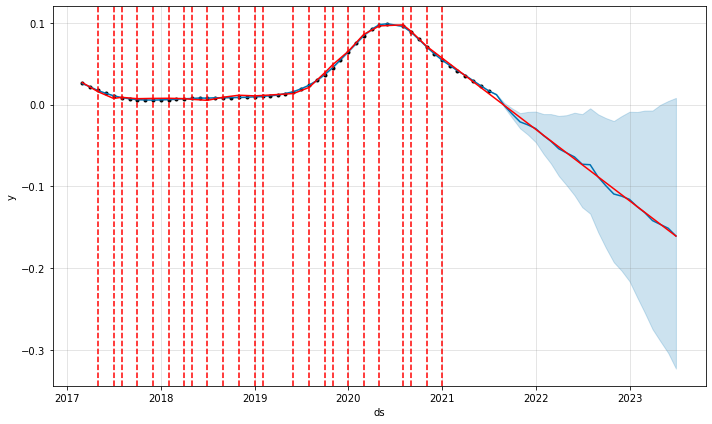

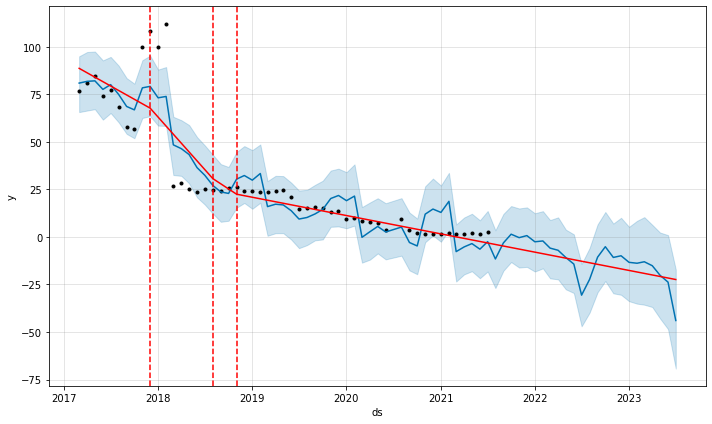

In [195]:
from fbprophet.plot import add_changepoints_to_plot
fig = wct.plot(wct_pred)
a = add_changepoints_to_plot(fig.gca(), wct, wct_pred)
fig2 = liq.plot(liq_pred)
a = add_changepoints_to_plot(fig2.gca(), liq, liq_pred)

In [84]:
liq_pred['ds']=pd.to_datetime(liq_pred['ds'])
liq_pred.loc[liq_pred['ds']>'2020']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
60,2020-03-01,5.157169,1.590381,8.796290,5.157169,5.157169,0.065418,0.065418,0.065418,0.065418,0.065418,0.065418,0.0,0.0,0.0,5.222587
61,2020-04-01,4.849188,0.889649,8.144498,4.849188,4.849188,-0.151502,-0.151502,-0.151502,-0.151502,-0.151502,-0.151502,0.0,0.0,0.0,4.697685
62,2020-05-01,4.551142,0.981573,8.084720,4.551142,4.551142,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.0,0.0,0.0,4.587709
63,2020-06-01,4.243161,0.791832,7.948273,4.243161,4.243161,0.071544,0.071544,0.071544,0.071544,0.071544,0.071544,0.0,0.0,0.0,4.314705
64,2020-07-01,3.945115,-1.576802,5.721732,3.945115,3.945115,-1.544448,-1.544448,-1.544448,-1.544448,-1.544448,-1.544448,0.0,0.0,0.0,2.400667
65,2020-08-01,3.637134,-1.438313,5.849981,3.637134,3.637134,-1.338882,-1.338882,-1.338882,-1.338882,-1.338882,-1.338882,0.0,0.0,0.0,2.298252
66,2020-09-01,3.329153,0.598240,7.816173,3.329153,3.329153,0.848261,0.848261,0.848261,0.848261,0.848261,0.848261,0.0,0.0,0.0,4.177414
67,2020-10-01,3.031107,-0.290692,6.626594,3.031107,3.031107,0.063176,0.063176,0.063176,0.063176,0.063176,0.063176,0.0,0.0,0.0,3.094283
68,2020-11-01,2.723126,0.685216,8.015755,2.723126,2.723126,1.828578,1.828578,1.828578,1.828578,1.828578,1.828578,0.0,0.0,0.0,4.551704
69,2020-12-01,2.425081,-0.877370,6.333164,2.425081,2.425081,0.394176,0.394176,0.394176,0.394176,0.394176,0.394176,0.0,0.0,0.0,2.819256


# Блок для прогнозирования на основании _decline curve_

In [434]:
from petbox import dca
from scipy.optimize import curve_fit

In [436]:
df.to_csv('smoothed.csv')

In [445]:
names = df.loc[(df.status=='prod')&(df['date']>'2015'), 'well'].unique()

In [446]:
def MH(time, qi, Di, bi, Dterm):
    Dterm = Di*Dterm
    m = dca.MH(qi=qi, Di=Di, bi=bi, Dterm=Dterm)
    return m.rate(time)

In [442]:
def dec_predict(frame):
    frame = frame.loc[(frame['date']>'2015')&(frame.status=='prod'), ['well', 'date', 'SOIL', 'QOIL']]
    name = frame['well'].unique()
    frame['Time'] = frame['date']-frame['date'].min()
    frame['Time'] = frame['Time'] / np.timedelta64(1, "D")
    shift = frame.loc[frame['QOIL']==frame['QOIL'].max(), 'Time']
    shift = int(shift.head(1).values)
    frame['Time']=frame['Time']-shift
    sub=frame.copy()
    sub=sub[sub['Time']>=0]
    frame['Time']=frame['Time']+shift
    last_deb = float(frame['QOIL'].tail(1))
    try:
        qi, Di = curve_fit(MH, sub['Time'], np.array(sub['SOIL']), bounds=(0, [100, 0.5, 0.5, 0.7]), method='trf')
    except ValueError:
        print(f'Ошибка определения темпа для скважины {name}')
        qi=[last_deb, 0.2, 0.2, 0.99] 
    except RuntimeError:
        print(f'Ошибка определения темпа для скважины {name}')
        qi=[last_deb, 0.2, 0.2, 0.99] 
    except:
        qi, Di = curve_fit(MH, sub['Time'], np.array(sub['SOIL']), bounds=(0, [100, 0.2, 0.2, 0.99]), method='dogbox')
    qi[3]=qi[1]*qi[3]
    mh = dca.MH(*qi)
#    print(name, shift, qi, sub['QOIL'])
    prog = pd.DataFrame(np.concatenate((sub.date, pd.date_range(sub.date.max(), periods=180, freq='MS')[1:])))#[1:]
    prog.columns=['date']
    prog['Time'] = prog['date']-prog['date'].min()
    prog['Time'] = prog['Time'] / np.timedelta64(1, "D")
    prog['rate'] = mh.rate(prog.Time)
    prog['month_prod'] = mh.monthly_vol(prog.Time)
    frame=pd.merge(frame, prog, left_on='date', right_on ='date', how='outer')
    frame['well'].fillna(method='ffill', inplace=True)
    if name=='10785':
        print(name, frame.tail(50))
    return frame

predict = pd.DataFrame(df.loc[df.well.isin(names)].groupby('well').apply(dec_predict))

In [448]:
predict=pd.DataFrame(columns=['well', 'date', 'SOIL', 'QOIL', 'Time_x', 'Time_y', 'rate', 'month_prod'])
for name, fr in df.loc[df.well.isin(names)].groupby('well'):
    predict = pd.concat([predict, dec_predict(fr)], ignore_index=True)

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['10763']
Ошибка определения темпа для скважины ['10766А']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['10777']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['10788']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['10811']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow enc

Ошибка определения темпа для скважины ['10849']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['10866']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['116']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['14929']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['14954']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['14990']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['15632']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other

Ошибка определения темпа для скважины ['15790']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow enc

Ошибка определения темпа для скважины ['17761']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['179Г']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other

Ошибка определения темпа для скважины ['20176']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\sci

Ошибка определения темпа для скважины ['20202']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['20298']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['20333']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['20399']
Ошибка определения темпа для скважины ['20402']
Ошибка определения темпа для скважины ['20404']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['20440']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated



Ошибка определения темпа для скважины ['20458']
Ошибка определения темпа для скважины ['20466']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['20489']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['20503']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['20531']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other

Ошибка определения темпа для скважины ['20570']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['20582']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['20593']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['20633']
Ошибка определения темпа для скважины ['20642']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['20678']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\sci

Ошибка определения темпа для скважины ['3133']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['3198']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['32646']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['32669']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['32677']
Ошибка определения темпа для скважины ['32680']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['32702']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['32723']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['32738']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\pet

Ошибка определения темпа для скважины ['32753']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['32785']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['3475']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other

Ошибка определения темпа для скважины ['681Д']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\

Ошибка определения темпа для скважины ['9604']


d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['9610']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power



Ошибка определения темпа для скважины ['9635']


d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\petbox\dca\primary.py:123: RuntimeWarning:

overflow encountered in power

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated

d:\other\my_software\anaconda\envs\times\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated



In [336]:
df[df.well=='10785'].head(50)

,№ скваж,Дата,Горизонт_x,Кол-во часов экспл всего по доб. скваж,"Добыча нефти за мес по скваж, т","Добыча воды за мес по скваж, т","Добыча воды за мес по скважине, м3",Кол-во часов работы всего по нагн. скваж,"Общая закачка всего по скваж за мес, м3",Горизонт_y,...,date,WCT,status,SBHPH,STHPH,SQLIQ,SWCT,SPROD,SOIL,PROD
17121,10785,1970-04-01,531.0,24.0,1.0,0.0,0.0,0.0,0.0,NaN,...,1970-04-01,0.000000,prod,NaN,NaN,0.654643,-0.003579,NaN,0.656986,NaN
17122,10785,1970-05-01,531.0,240.0,200.0,0.0,0.0,0.0,0.0,NaN,...,1970-05-01,0.000000,prod,NaN,NaN,3.031830,-0.003695,NaN,3.043032,NaN
17123,10785,1970-06-01,531.0,672.0,28.0,0.0,0.0,0.0,0.0,NaN,...,1970-06-01,0.000000,prod,NaN,NaN,5.368989,-0.003737,NaN,5.389052,NaN
17124,10785,1970-07-01,531.0,734.0,310.0,0.0,0.0,0.0,0.0,NaN,...,1970-07-01,0.000000,prod,NaN,NaN,7.646224,-0.003686,NaN,7.674405,NaN
17125,10785,1970-08-01,531.0,576.0,217.0,0.0,0.0,0.0,0.0,531.0,...,1970-08-01,0.000000,prod,NaN,NaN,9.845600,-0.003520,NaN,9.880254,NaN
17126,10785,1970-09-01,531.0,336.0,80.0,0.0,0.0,0.0,0.0,NaN,...,1970-09-01,0.000000,prod,NaN,NaN,11.949374,-0.003215,NaN,11.987794,NaN
17127,10785,1970-10-01,531.0,744.0,464.0,0.0,0.0,0.0,0.0,NaN,...,1970-10-01,0.000000,prod,NaN,NaN,13.938915,-0.002746,NaN,13.977191,NaN
17128,10785,1970-11-01,531.0,720.0,900.0,0.0,0.0,0.0,0.0,NaN,...,1970-11-01,0.000000,prod,NaN,NaN,15.794833,-0.002084,NaN,15.827747,NaN
17129,10785,1970-12-01,531.0,744.0,930.0,0.0,0.0,0.0,0.0,NaN,...,1970-12-01,0.000000,prod,NaN,NaN,17.499644,-0.001199,NaN,17.520632,NaN
17130,10785,1971-01-01,531.0,744.0,930.0,0.0,0.0,0.0,0.0,NaN,...,1971-01-01,0.000000,prod,NaN,NaN,19.041393,-0.000062,NaN,19.042567,NaN


<AxesSubplot:xlabel='date'>

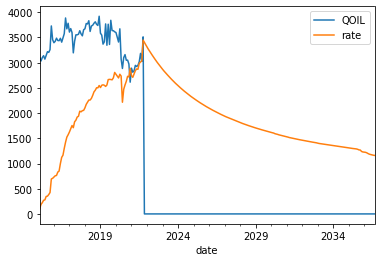

In [449]:
predict[['date','QOIL', 'rate']].groupby('date').agg('sum').plot()

## Участок анализ отклонений

In [450]:
predict.to_csv('decline.csv')

In [447]:
os.getcwd()

'e:\\FOX_EXPORT\\МИНН\\23.11.2021 15.36.35'

In [170]:
predict['dif'] = abs(predict['rate']-predict['QOIL'])

In [335]:
predict.reset_index(inplace=True, drop=True)

In [336]:
predict.groupby('well')['dif'].agg('mean').sort_values()#.hist(bins=100)

well
466    0.000000e+00
191    0.000000e+00
716    4.298784e-12
325    6.436096e-11
150    2.500655e-09
           ...     
435    1.182284e+01
27     1.357728e+01
513    1.552311e+01
506    1.552413e+01
371    1.841262e+01
Name: dif, Length: 232, dtype: float64

### Участок с тестированием отдельных участков кода для функции

In [369]:
t = dca.get_time()
month = dca.get_time_monthly_vol()

In [370]:
well='10785'

In [371]:
data = df.loc[(df['well']==well)&(df['date']>'2012')&(df.status=='prod')]#, ['date', 'SOIL', 'QOIL']]

In [372]:
float(data['QOIL'].tail(1).values)

0.0646900269541779

In [354]:
last_deb = data.loc[data['date']>data['date'].max(), 'QOIL']
last_deb

Series([], Name: QOIL, dtype: float64)

#### блок нормализации времени от начала работы скважины

In [355]:
data['Time'] = data['date']-data['date'].min()
data['Time'] = data['Time'] / np.timedelta64(1, "D")

<ipython-input-355-9a16526b44c0>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-355-9a16526b44c0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Вот тут находим максимальный уровень добычи, чтобы от него начать падение отстраивать

In [356]:
shift = data.loc[data['QOIL']==data['QOIL'].max(), 'Time']
shift = int(shift.head(1).values)
shift

151

In [357]:
data['Time']=data['Time']-shift
sub=data.loc[data.Time>=0]
data['Time']=data['Time']+shift

<ipython-input-357-556fdff809bd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-357-556fdff809bd>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [358]:
qi, Di = curve_fit(MH, sub['Time'], np.array(sub['QOIL']), bounds=(0, [100, 1, 1, 0.1]), method='trf')

In [359]:
qi[3]=qi[1]*qi[3]

In [360]:
qi

array([0.04336123, 0.0362901 , 0.99999752, 0.00181451])

['10852'] 943 [2.60751641e+00 1.00000000e-01 1.54890671e-06 3.50000000e-02] 0.6869829650959391\

In [361]:
mh = dca.MH(*qi)

In [362]:
q_mh = mh.rate(t)

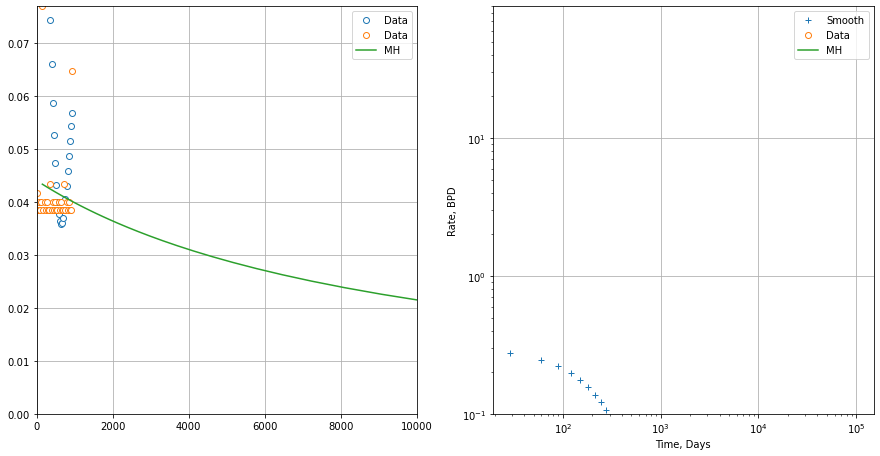

In [363]:
# Rate vs Time
fig = plt.figure(figsize=(15, 7.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(data['Time'], data['SOIL'], 'o', mfc='w', label='Data')
ax1.plot(data['Time'], data['QOIL'], 'o', mfc='w', label='Data')
#ax1.plot(t, q_thm, label='THM Transient')
#ax1.plot(t, q_trans, ls='--', label='THM Approx')
ax1.plot(t+shift, q_mh, label='MH')
#ax1.plot(t, q_ple, label='PLE')
#ax1.plot(t, q_se, label='SE')
#ax1.plot(t, q_dg, label='Duong')

#ax1.set(xscale='log', yscale='log', ylabel='Rate, BPD', xlabel='Time, Days')
ax1.set(ylim=(0, data['QOIL'].max()), xlim=(0, 1e4))
#ax1.set_aspect(1)
ax1.grid()
ax1.legend()

ax2.plot(data['Time'], data['SOIL'], '+', mfc='w', label='Smooth')
ax2.plot(data['Time'], data['QOIL'], 'o', mfc='w', label='Data')
#ax2.plot(t, q_thm, label='THM Transient')
#ax2.plot(t, q_trans, ls='--', label='THM Approx')
ax2.plot(t+shift, q_mh, label='MH')
#ax2.plot(t, q_ple, label='PLE')
#ax2.plot(t, q_se, label='SE')
#ax2.plot(t, q_dg, label='Duong')

ax2.set(xscale='log', yscale='log', ylabel='Rate, BPD', xlabel='Time, Days')
ax2.set(ylim=(1e-1, 9e1))#, xlim=(1e0, 1e5))
#ax2.set_aspect(1)
ax2.grid()
ax2.legend()


In [364]:
pred = pd.DataFrame(np.concatenate((sub.date, pd.date_range(sub.date.max(), periods=120, freq='MS'))))
pred.columns=['date']

In [365]:
pred['Time'] = pred['date']-pred['date'].min()
pred['Time'] = pred['Time'] / np.timedelta64(1, "D")

In [366]:
pred['rate'] = mh.rate(pred.Time)

In [367]:
pred['month_prod'] = mh.monthly_vol(pred.Time)

<AxesSubplot:>

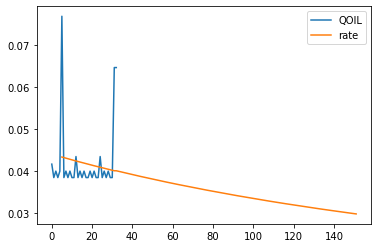

In [368]:
pd.merge(data, pred, left_on='date', right_on ='date', how='outer').loc[:,['QOIL', 'rate']].plot()#.iloc[100:,0]

In [272]:
pd.merge(data, pred, left_on='date', right_on ='date', how='outer')

,№ скваж,Дата,Горизонт_x,Кол-во часов экспл всего по доб. скваж,"Добыча нефти за мес по скваж, т","Добыча воды за мес по скваж, т","Добыча воды за мес по скважине, м3",Кол-во часов работы всего по нагн. скваж,"Общая закачка всего по скваж за мес, м3",Горизонт_y,...,STHPH,SQLIQ,SWCT,SPROD,SOIL,PROD,Time_x,Time_y,rate,month_prod
0,10852,2016-02-01,531.0,695.0,128.0,172.0,161.0,0.0,0.0,531.0,...,168.887216,10.006256,0.604899,0.155903,3.953483,NaN,0.0,NaN,NaN,NaN
1,10852,2016-03-01,531.0,724.0,146.0,161.0,151.0,0.0,0.0,NaN,...,168.872528,10.127875,0.611532,0.149737,3.934359,NaN,29.0,NaN,NaN,NaN
2,10852,2016-04-01,531.0,720.0,137.0,156.0,146.0,0.0,0.0,531.0,...,168.517501,10.245509,0.617554,0.144226,3.918358,NaN,60.0,NaN,NaN,NaN
3,10852,2016-05-01,531.0,605.0,108.0,175.0,163.0,0.0,0.0,531.0,...,167.935361,10.361948,0.623265,0.139671,3.903709,NaN,90.0,NaN,NaN,NaN
4,10852,2016-06-01,531.0,688.0,169.0,84.0,79.0,0.0,0.0,531.0,...,167.250771,10.479963,0.628919,0.136286,3.888911,NaN,121.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4625.0,0.001540,0.048102
182,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4656.0,0.001460,0.045623
183,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4686.0,0.001387,0.043345
184,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4717.0,0.001316,0.041111


In [32]:
df_new = pd.read_sql("select ngdu, god, mes, skw_id, t_rab, qnt_do, qn_ot from dbo.ot_dobf where ngdu=738", con=engine)

In [ ]:
os